# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from time import sleep

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, SpatialDropout1D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.layers import Flatten, InputSpec, Layer, Concatenate, AveragePooling2D, MaxPooling2D, Reshape, Permute
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D, LayerNormalization
from tensorflow.keras.layers import TimeDistributed, Lambda, AveragePooling1D, Add, Conv1D, Multiply
from tensorflow.keras.constraints import max_norm, unit_norm 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
import matplotlib.pyplot as plt

## Experiment Information
Record the experiment information in these fields to be saved with the experiment

In [17]:
trial_num = 3
attempt_num = 17
input_dim = 195
output_dim = 3
attempt_description = \
"""
## 17th attempt

### Changes made
- Trying the model with different dataset found online
    - https://www.nature.com/articles/sdata2018211
- Using the LR hand paradigm
    - Trying directly on Time seried data with model found online
    - https://github.com/vinayakr99/Muse-MotorImageryClassification/blob/main/MotorImagery_Training.ipynb
- 4 channels 170 samples per frame
- Trying to optimize the model for better results
- Trying with original model

### Expected results
- See if we can increase the validation accuracy to 90%

### Issues noticed
"""

In [18]:
# Make directories to save data
model_dir = './models/trial%s' % trial_num
results_dir = './results/trial%s/attempt%s' % (trial_num, attempt_num)
interm_dir = './processed_data/trial%s/attempt%s' % (trial_num, attempt_num)

model_file = os.path.join(model_dir, 'attempt%s.h5' % (attempt_num))
summary_file = os.path.join(results_dir, 'attempt%s_summary.txt' % attempt_num)
description_file = os.path.join(results_dir, 'attempt%s_readme.md' % attempt_num)
accuracy_graph = os.path.join(results_dir, 'attempt%s_accuracy.png' % attempt_num)
loss_graph = os.path.join(results_dir, 'attempt%s_loss.png' % attempt_num)
conf_matrix = os.path.join(results_dir, 'attempt%s_confusion.png' % attempt_num)
log_file = os.path.join(results_dir, 'attempt%s.log' % attempt_num)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(interm_dir):
    os.makedirs(interm_dir)
    
# Save description
with open(description_file, 'w') as f:
    f.write(attempt_description)
    f.close()


## Importing Data

In [ ]:
#### FOR RUNNING OPENBCI DATA ####
import scipy.io
mat = scipy.io.loadmat('./datasets/openbci_dataset/CLA-SubjectJ-170508-3St-LRHand-Inter.mat')
mat2 = scipy.io.loadmat('./datasets/openbci_dataset/CLA-SubjectJ-170510-3St-LRHand-Inter.mat')
data = np.concatenate((mat['o']['data'][0][0], mat2['o']['data'][0][0]))
labels = np.concatenate((mat['o']['marker'][0][0].flatten(),mat2['o']['marker'][0][0].flatten()))
print(labels.shape, data.shape)

### Try test file

In [ ]:
# Try test file

# Convert to numpy arrays
tp9, af7, af8, tp10 = data[621892-1000:621892+1000].T[:4]

# Get the frequency of the samples 
Twtp9, Wtp9, *_ = ssq_cwt(tp9, fs=200)

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(4, 1, 1)
plt.plot(data[621892-1000:621892+1000])
fig.add_subplot(4, 1, 3)
plt.imshow(np.abs(Twtp9), aspect='auto', cmap='turbo')
fig.add_subplot(4, 1, 2)
plt.imshow(np.abs(Wtp9), aspect='auto', cmap='turbo')
fig.add_subplot(4, 1, 4)
plt.plot(labels[621892-1000:621892+1000])
plt.show()


In [ ]:
##### For our data
segments = defaultdict(list)

# Number of samples per file
SEGMENT_SIZE = 170

# Number of channels per file
CHANNELS = [1, 2, 17, 18]
# CHANNELS = [i for i in range(1,23)]

# label_map = {1: "LEFT",
#              2: "RIGHT",
#              3: "PASSIVE",
#              0: "REMOVED"}

# Only use the left right passive signals
label_map = {1: "LEFT",
             2: "RIGHT",
             3: "PASSIVE"}

# Compile each 1s session into file
segment = []
for i in range(len(labels)):
    try:
        label = label_map[labels[i]]
    except KeyError:
        continue
    # Append the previous file and open new file
    if i+1 == len(labels) or labels[i] != labels[i+1] or len(segment) == SEGMENT_SIZE:
        # Split any that are large then FILE_SIZE and discard any that is smaller
        if len(segment) == SEGMENT_SIZE:
            segments[label].append(np.array(segment).T)
        segment = []
        
    segment.append(np.take(data[i], [chan - 1 for chan in CHANNELS]))
    
    
print("Total:")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(segments[val]), val, segments[val][0].shape))
    
max_num_segments = min([len(segments[key]) for key in label_map.values()])

train_segments = defaultdict(list)
test_segments = defaultdict(list)
val_segments = defaultdict(list)

#             [train, test, vali]
split_ratio = [0.8, 0.1, 0.1]

# Split the data to training test and val
for key in label_map.values():
    train_segments[key], test_segments[key], val_segments[key] = \
            np.split(shuffle(segments[key])[:max_num_segments], # Shuffle the data
                     [int(sum(split_ratio[:i+1])*max_num_segments) for i in range(len(split_ratio)-1)])

print("Training: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(train_segments[val]), val, train_segments[val].shape))
    
print("Testing: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(test_segments[val]), val, test_segments[val].shape))
    
print("Validation: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(val_segments[val]), val, val_segments[val].shape))
    

## Convert to wavelet transform signal squeezed

In [ ]:
SAMPLE_RATE = 200
def ts_to_ssq(timeseries):
    """
    Converts x channel time series data to ssq wavelet transform
    """
    ssqcwt = []
    for channel in timeseries:
        out, _, *_ = ssq_cwt(channel, fs=SAMPLE_RATE)
        ssqcwt.append(out)
    
    return np.array(ssqcwt)

In [ ]:
original_frame_size = SEGMENT_SIZE
buffer_frame_size = SEGMENT_SIZE # 0.85s
training_frame_size = 170
# training_sample_size = SEGMENT_SIZE
MAX_FREQ = 34

key_dict = {"LEFT":(1.0, 0.0, 0.0),
            "RIGHT":(0.0, 1.0, 0.0),
            "PASSIVE": (0.0, 0.0, 1.0)}


def compile_segments(segments, seg_type):
    X = []
    t = []
    
    num_segments = sum([len(x) for x in segments.values()])
    
    for key, data in segments.items():
        for recording in data:
            # if segment is smaller than sample size
            if len(recording[0]) < original_frame_size:
                continue

            # Split file into buffer size samples
            time_samples = np.split(recording,
                                    int(original_frame_size/buffer_frame_size), axis=1)

            for time_sample in time_samples:
                # Convert to numpy arrays
#                 ssq_data = ts_to_ssq(time_sample)

#                 # Take the magnitude of the wavelet transform only
#                 ssq_data = np.abs(ssq_data)
                
#                 # Trim unwanted frequencies
#                 ssq_data = ssq_data[:,:MAX_FREQ, :]

#                 # Split sample into many blocks
#                 wavelet_samples = np.dsplit(ssq_data, int(buffer_frame_size/training_frame_size))
                time_frames = np.hsplit(time_sample, int(buffer_frame_size/training_frame_size))

                X.extend(time_frames)
                t.extend([key_dict[key] for i in range(len(time_frames))])
                
            num_segments -= 1
            
            print("%d %s segments left to convert " % (num_segments, seg_type), end="\r")
                
    return np.array(X), np.array(t)

In [ ]:
# Compile all files into train data
X_train, t_train = compile_segments(train_segments, 'train')

X_test, t_test = compile_segments(test_segments, 'test')

X_val, t_val = compile_segments(val_segments, 'val')

In [ ]:
print("Training data")
print(X_train.shape)
print(t_train.shape)
print("Testing data")
print(X_test.shape)
print(t_test.shape)
print("Validation data")
print(X_val.shape)
print(t_val.shape)

In [ ]:
# Save the ssq data
np.save(os.path.join(interm_dir, 'x_train.npy'), X_train)
np.save(os.path.join(interm_dir, 't_train.npy'), t_train)
np.save(os.path.join(interm_dir, 'x_test.npy'), X_test)
np.save(os.path.join(interm_dir, 't_test.npy'), t_test)
np.save(os.path.join(interm_dir, 'x_val.npy'), X_val)
np.save(os.path.join(interm_dir, 't_val.npy'), t_val)


## *Shortcut: Load Preprocessed Saved Data*

In [19]:
# Load ssq data
interm_dir = './processed_data/trial3/attempt15/'
X_train = np.load(os.path.join(interm_dir, 'x_train.npy'))
t_train = np.load(os.path.join(interm_dir, 't_train.npy'))
X_test = np.load(os.path.join(interm_dir, 'x_test.npy'))
t_test = np.load(os.path.join(interm_dir, 't_test.npy'))
X_val = np.load(os.path.join(interm_dir, 'x_val.npy'))
t_val = np.load(os.path.join(interm_dir, 't_val.npy'))

## Shuffle data

In [5]:
# Shuffle the data
X_train, t_train = shuffle(X_train, t_train)
X_test, t_test = shuffle(X_test, t_test)
X_val, t_val = shuffle(X_val, t_val)

In [ ]:
X_train_full = X_train
X_train = X_train[:100]
t_train_full = t_train
t_train = t_train[:100]

In [ ]:
# Reshape the data for training
X_train = X_train.transpose(0, 3, 2, 1)

X_test = X_test.transpose(0, 3, 2, 1)

# Reshape the data for training
X_val = X_val.transpose(0, 3, 2, 1)

In [20]:
X_train.shape

(1359, 4, 170)

In [7]:
t_train.shape

(1359, 3)

In [ ]:
np.argwhere(np.isnan(X_train))

In [ ]:
counts = [0, 0, 0]
for data in t_train:
    for i in range(3):
        if data[i] == 1:
            counts[i] += 1
  
print("Balance of categories")
print(counts)

## Train Model

In [22]:
num_frames = len(X_train)
num_channels = len(X_train[0])
frame_size = len(X_train[0][0])

print('Training data dimensions = (%s, %s, %s)' % (num_frames, num_channels, frame_size))

n_ff = [2,4,8,16]    # Number of frequency filters for each inception module of EEG-ITNet
n_sf = [1,1,1,1]     # Number of spatial filters in each frequency sub-band of EEG-ITNet

drop_rate = 0.2

# Input layer
input_layer = Input(shape=(num_channels, frame_size, 1))

block1 = Conv2D(n_ff[0], (1, 16), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_1')(input_layer)
block1 = BatchNormalization()(block1)
block1 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[0], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_1')(block1)
block1 = BatchNormalization()(block1)
block1 = Activation('elu')(block1)

#================================

block2 = Conv2D(n_ff[1], (1, 32), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_2')(input_layer)
block2 = BatchNormalization()(block2)
block2 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[1], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_2')(block2)
block2 = BatchNormalization()(block2)
block2 = Activation('elu')(block2)

#================================

block3 = Conv2D(n_ff[2], (1, 64), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_3')(input_layer)
block3 = BatchNormalization()(block3)
block3 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[2], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_3')(block3)
block3 = BatchNormalization()(block3)
block3 = Activation('elu')(block3)

#================================

block4 = Conv2D(n_ff[3], (1, 128), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_4')(input_layer)
block4 = BatchNormalization()(block4)
block4 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[3], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_4')(block4)
block4 = BatchNormalization()(block4)
block4 = Activation('elu')(block4)

#================================

block = Concatenate(axis = -1)([block1, block2, block3, block4]) 

#================================

block = AveragePooling2D((1, 4))(block)
block_in = Dropout(drop_rate)(block)

#================================

paddings = tf.constant([[0,0], [0,0], [3,0], [0,0]])
block = tf.pad(block_in, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_in, block])


paddings = tf.constant([[0,0], [0,0], [6,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block])


paddings = tf.constant([[0,0], [0,0], [12,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block]) 


paddings = tf.constant([[0,0], [0,0], [24,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block]) 

#================================

block = block_out

#================================

block = Conv2D(28, (1,1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = AveragePooling2D((1,4), data_format='Channels_last')(block) #'Channels_last' As CPU will be used for inference
block = Dropout(drop_rate)(block) 
embedded = Flatten()(block)

output = Dense(len(t_train[0]), activation='softmax', kernel_constraint = max_norm(0.2))(embedded)
    
model = Model(inputs=input_layer, outputs=output)

Training data dimensions = (1359, 4, 170)


In [23]:
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, clipvalue=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
with open(summary_file, 'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    fh.close()
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 170, 1)]  0                                            
__________________________________________________________________________________________________
Spectral_filter_1 (Conv2D)      (None, 4, 170, 2)    32          input_1[0][0]                    
__________________________________________________________________________________________________
Spectral_filter_2 (Conv2D)      (None, 4, 170, 4)    128         input_1[0][0]                    
__________________________________________________________________________________________________
Spectral_filter_3 (Conv2D)      (None, 4, 170, 8)    512         input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.get_weights()

In [25]:
stdout = sys.stdout
f = open(log_file, 'w')
sys.stdout = f
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
try:
    results = model.fit(X_train, t_train, validation_data=(X_val, t_val), batch_size=32, epochs=500, shuffle=True, callbacks=[model_checkpoint_callback])
    sys.stdout = stdout
    f.close()
except Exception as e:
    sys.stdout = stdout
    f.close()
    print(e)
except KeyboardInterrupt as e:
    sys.stdout = stdout
    f.close()
    print(e)

In [ ]:
sys.stdout = stdout
f.close()

In [ ]:
# To save the model
model.save(model_file)

In [26]:

model = tf.keras.models.load_model(model_file)

In [27]:
test_results = model.evaluate(X_test, t_test, batch_size = 1)

171/171 [==============================] - 1s 8ms/step - loss: 0.5434 - accuracy: 0.7895


In [ ]:
model.predict(X_test)

In [ ]:
t_test

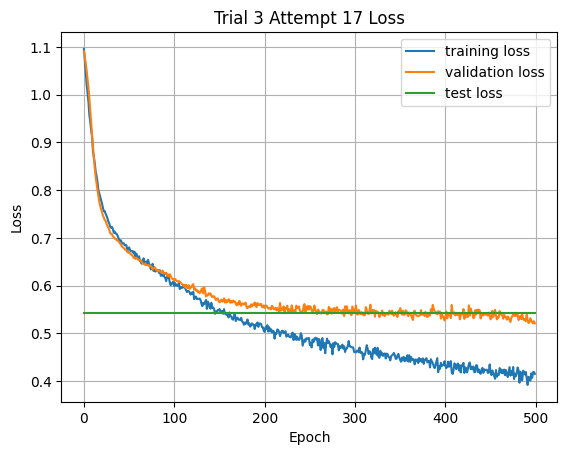

In [28]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.plot([test_results[0] for i in range(len(results.history['loss']))])
plt.legend(('training loss', 'validation loss', 'test loss'))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trial %s Attempt %s Loss" % (trial_num, attempt_num))
plt.grid()
plt.savefig(loss_graph)

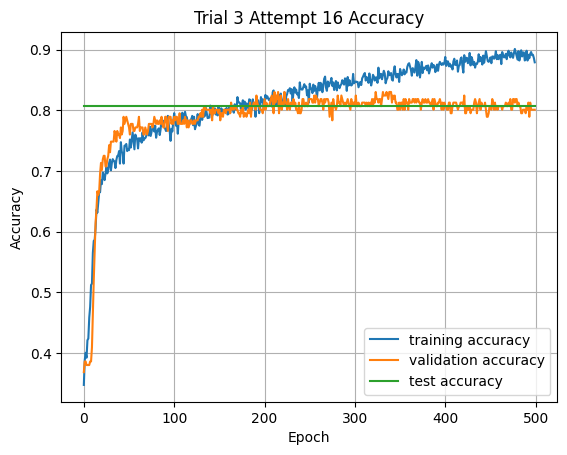

In [15]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.plot([test_results[1] for i in range(len(results.history['accuracy']))])
plt.legend(('training accuracy', 'validation accuracy', 'test accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Trial %s Attempt %s Accuracy" % (trial_num, attempt_num))
plt.grid()
plt.savefig(accuracy_graph)

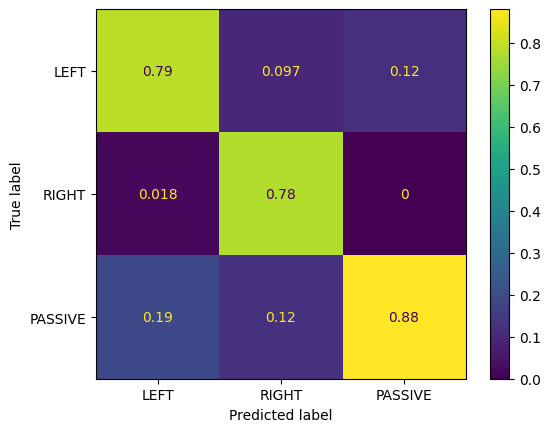

In [16]:
key_dict = {"LEFT":(1.0, 0.0, 0.0),
            "RIGHT":(0.0, 1.0, 0.0),
            "PASSIVE": (0.0, 0.0, 1.0)}

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(t_test, axis=1)

cm = confusion_matrix(y_test, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=key_dict.keys())
plot = disp.plot()
disp.figure_.savefig(conf_matrix)

In [21]:
tf.keras.backend.clear_session()

# Model Visualization

## Input

In [ ]:
print(X_test[0].T.shape)
plt.imshow(X_test[0].T, interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('Spectral_filter_1').output)
output = probe.predict(X_test[:1]).transpose(0, 3, 2, 1)
print(output.shape)
rows = 1
for num, data in enumerate(output[0]):
    plt.subplot(rows, int(len(output[0])/rows), num+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('Spatial_filter_1').output)
output = probe.predict(X_test[:1]).transpose(0, 3, 2, 1)
print(output.shape)
for num, data in enumerate(output[0]):
    plt.subplot(rows, int(len(output[0])/rows), num+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('activation').output)
output = probe.predict(X_test[:1]).transpose(0, 3, 2, 1)
print(output.shape)
for num, data in enumerate(output[0]):
    plt.subplot(rows, int(len(output[0])/rows), num+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('Spectral_filter_2').output)
output = probe.predict(X_test[:1]).transpose(0, 3, 2, 1)
print(output.shape)
for num, data in enumerate(output[0]):
    plt.subplot(1, 2, num%2+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()
    if num%2:
        plt.show()

In [ ]:
probe = Model(model.input, model.get_layer('Spectral_filter_3').output)
output = probe.predict(X_test[:1]).transpose(0, 3, 2, 1)
print(output.shape)
for num, data in enumerate(output[0]):
    plt.subplot(1, 2, num%2+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()
    if num%2:
        plt.show()

In [ ]:
probe = Model(model.input, model.get_layer('Spectral_filter_4').output)
output = probe.predict(X_test[:1]).transpose(0, 3, 2, 1)
print(output.shape)
for num, data in enumerate(output[0]):
    plt.subplot(1, 2, num%2+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()
    if num%2:
        plt.show()

In [ ]:
probe = Model(model.input, model.get_layer('concatenate').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('averag_pooling2d').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('average_pooling2d').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('dropout').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('depthwise_conv2d').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('depthwise_conv2d_1').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('add').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('add_1').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('add_2').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('add_3').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('conv2d').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.title(t_test[0])
plt.colorbar()

In [ ]:
probe = Model(model.input, model.get_layer('dropout_9').output)

rows = 3

f, axarr = plt.subplots(3, 10)
row_counts = [0 for i in range(rows)]

for i in range(50):
    output = probe.predict(np.array([X_test[i]]))
    if t_test[i][0]:
        row = 0
    elif t_test[i][1]:
        row = 1
    else:
        row = 2
    
    try:
        axarr[row, row_counts[row]].imshow(output[0][0], interpolation='nearest', aspect='auto')
        axarr[row, row_counts[row]].axis('off')
        axarr[row, row_counts[row]].axis('off')
        
    except:
        pass
    row_counts[row] += 1